# Transient Analysis

## Imports

In [1]:

"""Setup, This should not need to be edited"""
%load_ext autoreload
%autoreload 2

# Photontorch
import sys
sys.path.append('.')
import photontorch as pt
# Python
import torch
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widge
from tqdm.notebook import trange

# numpy settings
DEVICE = 'cuda'
c = 299792458.0 #[m/s] speed of light
Rb = 20e9 #[1/s] bitrate
Rs = 320e9 #[1/s] samplerate
fc = 20e9 #[1/s] cutoff frequency for bit generation
wl0 = 1550e-9 #[m] center wavelength
neff = 2.34 #[1] effective index
ng = 3.4 #[1] group index
"""N and B dont do anything??"""
N = 100 #[1] number of bits per bit stream
B = 10 #[1] number of bit streams in training batch 

Str, Sva, Ste = (1, 2, 3) #[1] train seed, validation seed, test seed
Lr = (1/Rb) * (c/ng) #[m] reference length (distance the signal travels during one bit period)
device = torch.device(DEVICE) # default device used
torch.set_default_dtype(torch.float32) # default dtype used
torch.manual_seed(123) # pytorch seed
np.random.seed(42) # numpy seed
np.set_printoptions(precision=2, suppress=True) # show less numbers while printing numpy arrays


## Enivornment Setup

In [2]:

length = 25e-6 #[m] #default length
transmission = 0.5 #[]
neff = 2.86
env = pt.Environment(
    t_start = 0,
    t_end = 1000e-13,
    dt = 1e-13,
    wl = 1.55e-6,#
)
env_fd = pt.Environment(freqdomain=True, num_t=1, grad=True)
pt.set_environment(env)


phi_set = theta_set = np.nan
modulator_start_error = waveguide_error = 1

## Network Visualization

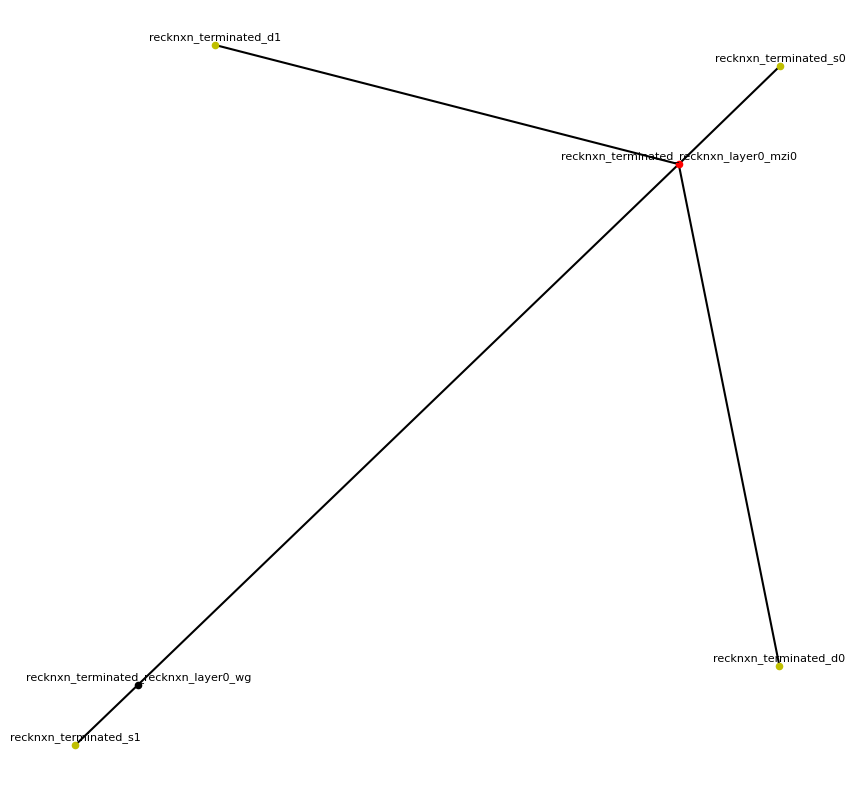

In [3]:
"""Network visualization is not pretty, but it does its job in showing the connections"""
Simple_Reck = pt.ReckNxN(
    N=2,#number of inputs
    wg_factory=lambda: pt.Waveguide(phase=0,trainable=True),#optionally change phases, by default, the phases are randomized
    mzi_factory=lambda: pt.Mzij(
                               #phi=0,#optionally change the input modulator phase, defaults to a random value
                               #theta=0,#optionally change the modulator phase, defaults to a random value
                               trainable=True,#says whether phi and theta can be changed in a neural network training
                              normalize = True,#option only on the mzij and the mzm, this normalizes the lookup table from ansys
                             debug_print=False),#just used for houskeeping, probably will give unintelligible values
).terminate()
Simple_Reck.graph() # hand written visualization function, does not work on large networks so set N<4~ish


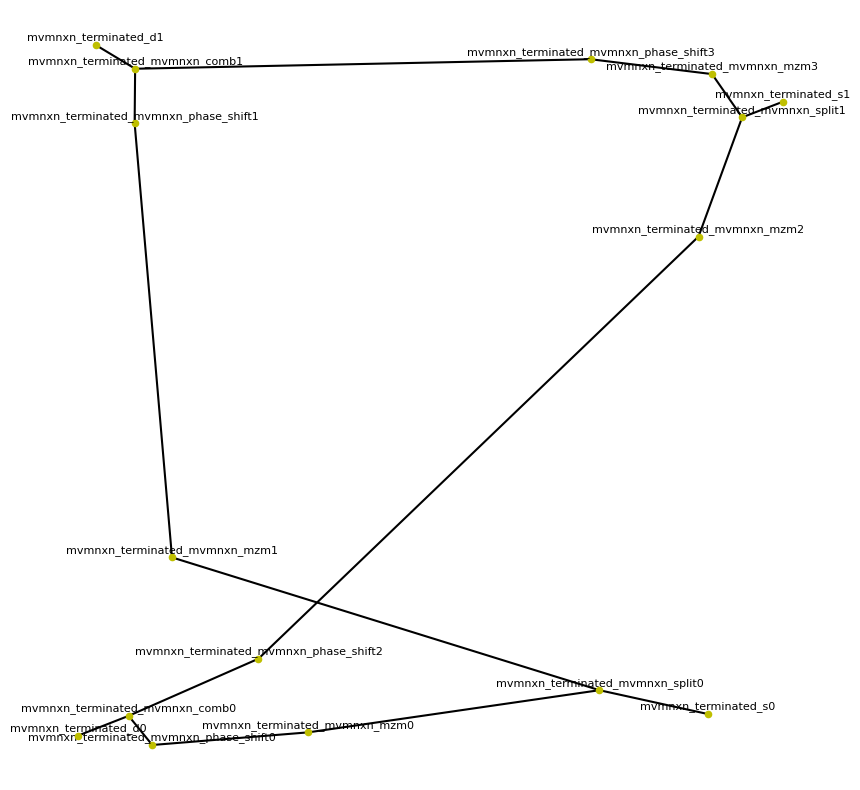

In [4]:

Simple_MVM = pt.MVMNxN(
    N=2,#number of inputs
    mzm_factory=lambda: pt.Mzm(
                               #phi=0,#optionally change the input modulator phase, defaults to a random value
                               #theta=0,#optionally change the modulator phase, defaults to a random value
                               trainable=True,#says whether phi and theta can be changed in a neural network training
                              normalize = True,#option only on the mzij and the mzm, this normalizes the lookup table from ansys
                             debug_print=False),#just used for houskeeping, probably will give unintelligible values
).terminate()
import networkx as nx
#this should use the default layout You can go through the layouts in the networkx library to find the best one.
#spring works best for a 2X2 MVM and is the default. if you graph a not fully connected system use multipartiate_layout
Simple_MVM.graph(nx.spring_layout) # hand written visualization function, does not work on large networks so set N<4~ish


## Component Simulations

(200, 2)


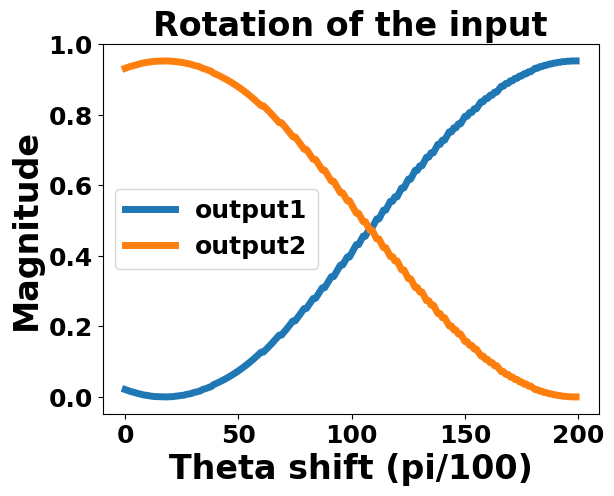

In [16]:
Normalize_MVM = False

MZI_sim_outputs = []
MZI_sim_input_N = 2
MZI_sim_inputs = torch.zeros(MZI_sim_input_N, names=["s"])#create an N dimentional array
MZI_sim_inputs[0] = 1 #set the first input high 

for i in range(200):
   
    MZI_sim = pt.ReckNxN(
        N=MZI_sim_input_N, #minimum number of inputs for a Reck network is 2. At which point it is just a interferometer
        mzi_factory=lambda: pt.Mzij(
                                theta=i*np.pi/100,#the reason for the /100 is that the ansys simulations have 200 quantizations for a 2 pi shift
                                trainable=True,
                                normalize = Normalize_MVM,
                                debug_print=False,
                                ),
    ).terminate() #the .terminate says to autoconnect inputs and outputs to sources/detectors, you can chain networks if you dont call this
    pt.set_environment(env_fd)#environment set at the top, used for plotting IDK why it has to be done in the for loop, but it runs forever if not here
    
    MZI_sim_magnitude = MZI_sim(MZI_sim_inputs)[:,0,:,0]
    MZI_sim_magnitude = MZI_sim_magnitude.detach().numpy()[0]
    MZI_sim_outputs += [MZI_sim_magnitude]
com = np.array(np.copy(MZI_sim_outputs))
print(np.shape(MZI_sim_outputs))
x_values = range(len(MZI_sim_outputs))  # Assuming both outputs have the same length
plt.plot(x_values, com[:, 0], label='output1', linewidth=5)  # Plotting the first output
plt.plot(x_values, com[:, 1], label='output2', linewidth=5)  # Plotting the second output

plt.xlabel('Theta shift (pi/100)', fontsize=24, fontweight='bold')
plt.ylabel('Magnitude', fontsize=24, fontweight='bold')
plt.rcParams.update({'font.size': 18, 'font.weight': 'bold'})
plt.title('Rotation of the input', fontsize=24, fontweight='bold')
plt.legend()

Text(0, 0.5, 'Magnitude')

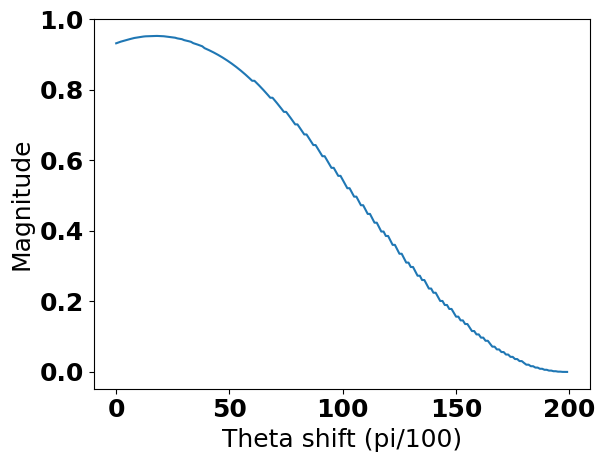

In [6]:
import sys
from io import StringIO


MZM_sim_outputs = []
MZM_sim_input_N = 1
MZM_sim_inputs = torch.zeros(MZM_sim_input_N, names=["s"])#create an N dimentional array
MZM_sim_inputs[0] = 1 #set the first (and only) input high 

for i in range(200):
    MZM_sim = pt.MVMNxN(
        N=MZM_sim_input_N, #minimum number of inputs for a Matrix vector multiplier is 1 At which point it is just a modulator
        mzm_factory=lambda: pt.Mzm(
                                theta=i*np.pi/100,#the reason for the /100 is that the ansys simulations have 200 quantizations for a 2 pi shift
                                trainable=True,
                                normalize = Normalize_MVM,
                                debug_print=False,
                                ),
    ).terminate() #the .terminate says to autoconnect inputs and outputs to sources/detectors, you can chain networks if you dont call this
    pt.set_environment(env_fd)#environment set at the top, used for plotting IDK why it has to be done in the for loop, but it runs forever if not here
    
    MZM_sim_magnitude = MZM_sim(MZM_sim_inputs)
    MZM_sim_magnitude=MZM_sim_magnitude[:,0,:,0]
    MZM_sim_magnitude = MZM_sim_magnitude.detach().numpy()[0]
    MZM_sim_outputs += [MZM_sim_magnitude]


x_values = range(len(MZM_sim_outputs))
plt.plot(x_values, MZM_sim_outputs)
plt.xlabel('Theta shift (pi/100)')
plt.ylabel('Magnitude')



## Matrix Vector Multiplier Simulation

In [7]:
"""First we want to create a lookup table based on the single component simulation so we know what we are multipliying by"""
def attenuation_lookup(multiplicand):
    output_matrix=np.zeros(np.shape(multiplicand))
    for i in range(np.shape(multiplicand)[0]):
        for j in range(np.shape(multiplicand)[1]):
            output_matrix[i, j] = np.argmin(np.abs(MZM_sim_outputs - multiplicand[i, j]))
    return output_matrix*np.pi/100      

"""next we want to define our inputs"""

N=3 # for a 3X3 array

weight_matrix =    np.array([[1, 2, 3],
                            [4, 5, 6],
                            [7, 8, 9]])
init_weight_matrix = np.array(weight_matrix.copy())


input_vector = torch.zeros(N,names=["s"])
input_vector[0]=1
input_vector[1]=2
input_vector[2]=3
#print("expected outputs: ",np.dot(np.array(weight_matrix),np.array(input_vector)))
"""we have to do some preprocessing, first the weights cannot be >1"""
max_weight = np.max(weight_matrix)
weight_matrix = weight_matrix/max_weight #normalize from the largest input
weight_matrix = attenuation_lookup(weight_matrix)
input_magnitude = input_vector.sum()

print("input weight matrix: \n",init_weight_matrix)
print("theta shifts for the modulators (radians): \n", weight_matrix)






input weight matrix: 
 [[1 2 3]
 [4 5 6]
 [7 8 9]]
theta shifts for the modulators (radians): 
 [[5.   4.4  3.93]
 [3.49 3.08 2.67]
 [2.14 1.51 0.53]]


In [8]:
#this cell takes approximately 2-3 minutes to run
phase_correction = np.zeros((3,3))
epochs = 5
#train the phases before the combiner, this may take a while
for e in range(epochs):
    for p in range(N):
        for q in range(N):
            mvm_sim_outputs=[]
            for i in range(100):
                
                phase_correction[p,q]=i*np.pi/100
                
                MVM_sim = pt.MVMNxN(
                N=N, #minimum number of inputs for a Matrix vector multiplier is 1 At which point it is just a modulator
                weights=weight_matrix,
                phase_weights = phase_correction,
                normalize = Normalize_MVM,
                ).terminate()
                pt.set_environment(env_fd)
                MVM_magnitudes = MVM_sim(input_vector)[:,0,:,0]
                MVM_magnitudes = MVM_magnitudes.detach().numpy()[0]#converting from tensor to numpy array, also it has an extra dimensionality we have to remove
                MVM_magnitudes=MVM_magnitudes*max_weight/input_magnitude.item()#re-multiply by the scalar we took out in pre processing
                mvm_sim_outputs+=[MVM_magnitudes[q]]
                if i > 0:
                    if mvm_sim_outputs[i]<mvm_sim_outputs[i-1]: #this if statement is a massive time saver but it may reduce accuracy
                        break
            phase_correction[p,q]=np.argmax(mvm_sim_outputs)*np.pi/100
        


In [9]:
print(phase_correction)

MVM_sim = pt.MVMNxN(
    N=N, #minimum number of inputs for a Matrix vector multiplier is 1 At which point it is just a modulator
    weights=weight_matrix,
    phase_weights = phase_correction,
    normalize = Normalize_MVM,
).terminate()
pt.set_environment(env_fd)
MVM_magnitudes = MVM_sim(input_vector)[:,0,:,0]
MVM_magnitudes = MVM_magnitudes.detach().numpy()[0]#converting from tensor to numpy array, also it has an extra dimensionality we have to remove
MVM_magnitudes=MVM_magnitudes*max_weight/input_magnitude.item()#re-multiply by the scalar we took out in pre processing
print("Weight array: \n",init_weight_matrix)
print("Input vector: ",input_vector.detach().numpy())
calculated = np.dot(np.array(init_weight_matrix),np.array(input_vector))
print("Calculated output (dot product): ",calculated)
print("Measured outputs: ",MVM_magnitudes)


[[0.   0.   0.  ]
 [0.28 0.22 0.31]
 [0.57 0.47 0.85]]
Weight array: 
 [[1 2 3]
 [4 5 6]
 [7 8 9]]
Input vector:  [1. 2. 3.]
Calculated output (dot product):  [14. 32. 50.]
Measured outputs:  [13.6  31.82 48.65]


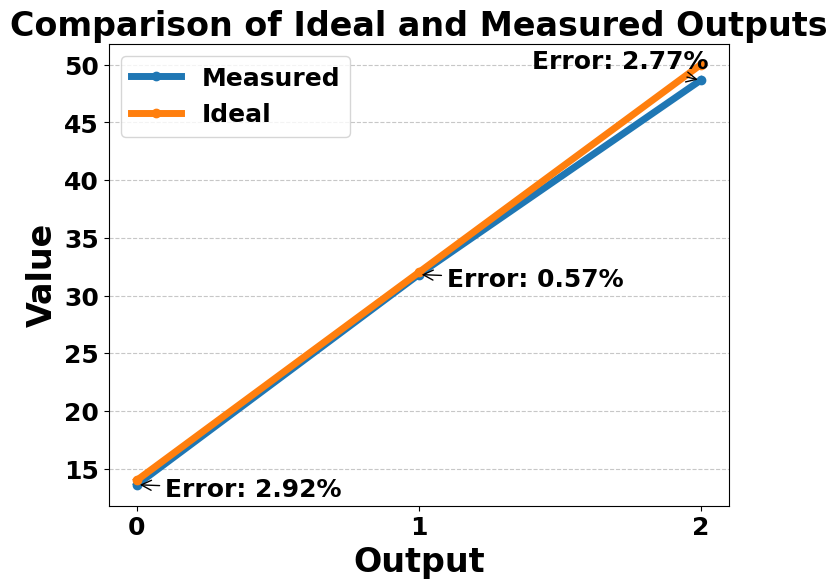

In [10]:
# Calculate percentage errors
percentage_errors = np.abs((calculated - MVM_magnitudes) / MVM_magnitudes) * 100

# Plotting
plt.figure(figsize=(8, 6))

# Plot measured output
plt.plot(MVM_magnitudes, label='Measured', marker='o',linewidth=5)

# Plot calculated output
plt.plot(calculated, label='Ideal', marker='o',linewidth=5)

# Annotate percentage errors
for i, err in enumerate(percentage_errors):
    if i == 2:  # Adjust only the annotation at index 1
        plt.annotate(f'Error: {err:.2f}%', xy=(i, MVM_magnitudes[i]), xytext=(i-.6, MVM_magnitudes[i]+1),
                     arrowprops=dict(facecolor='red', arrowstyle='->'))
    elif i == 0:  # Adjust only the annotation at index 1
        plt.annotate(f'Error: {err:.2f}%', xy=(i, MVM_magnitudes[i]), xytext=(i+.1, MVM_magnitudes[i]-1),
                     arrowprops=dict(facecolor='red', arrowstyle='->'))
    else:
        plt.annotate(f'Error: {err:.2f}%', xy=(i, MVM_magnitudes[i]), xytext=(i+0.1, MVM_magnitudes[i]-1),
                     arrowprops=dict(facecolor='red', arrowstyle='->'))

plt.ylabel('Value',fontsize=24, fontweight='bold')
plt.xlabel('Output',fontsize=24, fontweight='bold')
plt.title('Comparison of Ideal and Measured Outputs',fontsize=24, fontweight='bold')
plt.rcParams.update({'font.size': 18, 'font.weight': 'bold'})
plt.xticks(range(len(calculated)))  # Set integer ticks on x-axis
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Only y-axis gridlines
plt.legend()
plt.show()


In [11]:

"""


N = 1#size_select.value
all_high_input = torch.ones(N, names=["s"]) #/ np.sqrt(N) # Source tensors with less than 4D need to have named dimensions.

Matrix multiplixation test
the previous cell shows the generation of a Lookup table for the attenuation of a single modulator
We can now take this and apply it to a large 


"""


'\n\n\nN = 1#size_select.value\nall_high_input = torch.ones(N, names=["s"]) #/ np.sqrt(N) # Source tensors with less than 4D need to have named dimensions.\n\nMatrix multiplixation test\nthe previous cell shows the generation of a Lookup table for the attenuation of a single modulator\nWe can now take this and apply it to a large \n\n\n'

In [12]:
'''
detected_time = network_reck(all_high_input)
network_reck.plot(detected_time[:, 0, :, 0]); # plot first and only batch
# convergence analysis 

                
detected_time[:, 0, :, 0]'''

'\ndetected_time = network_reck(all_high_input)\nnetwork_reck.plot(detected_time[:, 0, :, 0]); # plot first and only batch\n# convergence analysis \n\n                \ndetected_time[:, 0, :, 0]'

In [13]:
'''pt.set_environment(env_fd)
detected_freq_mag = network_reck(all_high_input)[:,0,:,0]
detected_freq_mag = detected_freq_mag.detach().numpy()[0]
plt.bar(np.arange(0,N),detected_freq_mag)
print(f"totaloutput", np.sum(detected_freq_mag))
plt.title("Output Magnitude")'''

'pt.set_environment(env_fd)\ndetected_freq_mag = network_reck(all_high_input)[:,0,:,0]\ndetected_freq_mag = detected_freq_mag.detach().numpy()[0]\nplt.bar(np.arange(0,N),detected_freq_mag)\nprint(f"totaloutput", np.sum(detected_freq_mag))\nplt.title("Output Magnitude")'

In [14]:
'''outputs_0 = []
outputs_1 = []
for i in range(128):
    network_reck = pt.ReckNxN(
        N=N,
        mzi_factory=lambda: pt.Mzij(
                                theta=i*np.pi/64,
                                trainable=True,
                                normalize = True,
                                debug_print=False),
    ).terminate()
    pt.set_environment(env_fd)
    detected_freq_mag = network_reck(all_high_input)[:,0,:,0]
    detected_freq_mag = detected_freq_mag.detach().numpy()[0]
    outputs_0 += [detected_freq_mag[0]]
    outputs_1 += [detected_freq_mag[1]]
    #print(f"totaloutput", np.sum(detected_freq_mag))
    
x_values = range(len(outputs_0))
plt.plot(x_values, outputs_0)
x_values = range(len(outputs_1))
plt.plot(x_values, outputs_1)
'''

'outputs_0 = []\noutputs_1 = []\nfor i in range(128):\n    network_reck = pt.ReckNxN(\n        N=N,\n        mzi_factory=lambda: pt.Mzij(\n                                theta=i*np.pi/64,\n                                trainable=True,\n                                normalize = True,\n                                debug_print=False),\n    ).terminate()\n    pt.set_environment(env_fd)\n    detected_freq_mag = network_reck(all_high_input)[:,0,:,0]\n    detected_freq_mag = detected_freq_mag.detach().numpy()[0]\n    outputs_0 += [detected_freq_mag[0]]\n    outputs_1 += [detected_freq_mag[1]]\n    #print(f"totaloutput", np.sum(detected_freq_mag))\n    \nx_values = range(len(outputs_0))\nplt.plot(x_values, outputs_0)\nx_values = range(len(outputs_1))\nplt.plot(x_values, outputs_1)\n'

In [15]:
'''print(np.max(outputs))
print(np.argmax(outputs))'''

'print(np.max(outputs))\nprint(np.argmax(outputs))'